In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')
# 不发出警告

print('成功')

成功


### 1、蒙特卡洛思想是啥？

In [4]:
# 计算 pi
from matplotlib.patches import Circle
# 投点次数
n = 10000

r = 1 #半径

#圆心
a = 0.0
b = 0.0
#正方形边界
xmin = a - r
xmax = a + r

ymin = b - r
ymax = b + r

#随机生成10000个点
x = np.random.uniform(xmin, xmax, n)
y = np.random.uniform(ymin, ymax, n)

#计算点到圆心的距离
#统计落在圆内的点的数目
d = np.sqrt((x-a)**2  + (y-b)**2)
res = sum(np.where(d<r , 1 ,0))

pi = 4 * res /n # monte Carlo 方法：用统计值去近似真实值
#正方形的内切圆面积/正方形面积=落入圆内的点/落入正方形内的点
print(pi)


3.1584


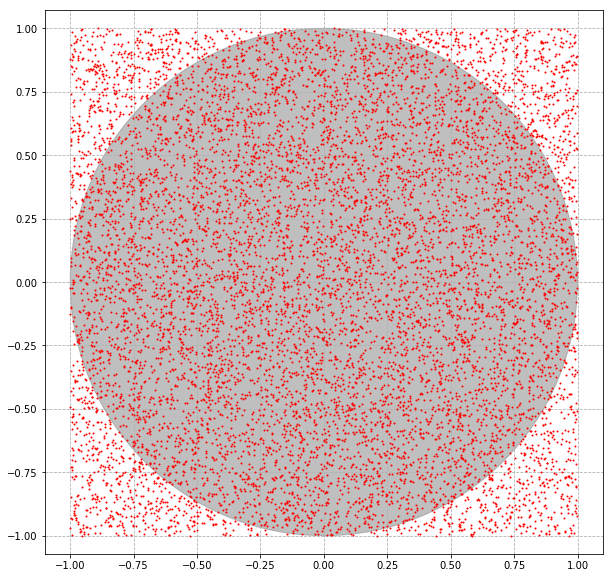

In [10]:
fig = plt.figure(figsize=(10, 10))
axes = fig.add_subplot(1,1,1)
plt.plot(x,y,'ro', markersize = 1)
plt.axis('equal')

#同一个画布上绘制圆形
circle = Circle(xy=(a,b), radius = 1,alpha = 0.5, color = 'gray')
axes.add_patch(circle)
plt.grid(True, linestyle = '--', linewidth  = '0.8')

### 2、社会财富分配模型
模型假设：
1）每个人初始基金100元
2) 从18岁到65岁，每天玩一次，简化运算按照一共玩17000天
3) 每天拿出一元钱，并且随机分配给另一个人 
4) 当某人的财富值降到0元时，他在该轮无需拿出1元钱给别人，但仍然有机会得到别人给出的钱
第一轮游戏分配 先不考虑某人财富值降到0元的情况。
参考文章：《该如何面对这个残酷的世界？》 https://mp.weixin.qq.com/s?__biz=MzAwNTkyNDExOQ==&mid=2247486489&idx=1&sn=cb18dab40fcd101ae6e2b4b4871fde46&chksm=9b147861ac63f17787fc5450f134ae8c92a456bac086ffbdf0475e2abdbbd73da81b42c9f86d&mpshare=1&scene=1&srcid=0509AW5SQkOiVichptU2M7IB#rd

In [28]:
'''
(1) 模拟第一轮游戏分配
考虑情况： 当某人的财富值降为0元时，他在该轮无需拿出1元钱给别人，但仍然是有机会的
得到别人给出的钱
'''
# 设定初始参数：游戏是玩家100人，起始资金100元
person_n = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for i in range(100)],index=person_n)
fortune.index.name = 'id'

fortune.head()
# 第一轮开始前情况设置,财富值为0的人不需要给钱给别人
round_r1 = pd.DataFrame({'pre_round':fortune[0],'lost':0})
round_r1['lost'][round_r1['pre_round']>0] = 1

# 筛选出参与游戏的玩家：财富值>0
round_player = round_r1[round_r1['pre_round'] > 0]
round_player.head()
len(round_player)

#随机产生100个编号，作为给1元的对象
choice_r1 = pd.Series(np.random.choice(person_n,len(round_player)))
#统计各对象收获的财富值
gain_r1 = pd.DataFrame({'gain':choice_r1.value_counts()})
gain_r1.head()

round_r1 = round_r1.join(gain_r1)
round_r1.fillna(0,inplace = True) #缺失值填0
#计算第一轮后，各对象的最终财富值
fortune[1] = round_r1['pre_round'] - round_r1['lost'] + round_r1['gain']

fortune.head()

,0,1
id,,
1,100,100.0
2,100,99.0
3,100,100.0
4,100,99.0
5,100,102.0


In [45]:
'''
(2)构建函数模型。注意：当某人的财富值降到0元时，他在该轮不需要拿出1元钱给别人，
但仍然有机会获得别人给出的钱
'''
def game1(data, roundi): # data 为开始新一轮时的财富状况，roundi为目前进行游戏的次数
    if len(data[data[roundi - 1] == 0]) > 0:
        #对于含有当前财富值为0 的游戏者处理策略
        round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':0})
        con = round_i['pre_round'] > 0
        round_i['lost'][con] = 1
        round_player_i = round_i[con]
        choice_i = pd.Series(np.random.choice(person_n, len(round_player_i)))
        gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
        
        round_i = round_i.join(gain_i)
        round_i.fillna(0,inplace=True)
        return round_i['pre_round'] - round_i['lost'] + round_i['gain']
    else:
        # 对于不包含财富值为0 的状况
        round_i = pd.DataFrame({'pre_round':data[roundi-1],'lost':1})
        choice_i = pd.Series(np.random.choice(person_n, len(round_i)))
        gain_i = pd.DataFrame({'gain':choice_i.value_counts()})
        round_i = round_i.join(gain_i)
        round_i.fillna(0,inplace=True)
        return  round_i['pre_round'] - round_i['lost'] + round_i['gain']
    #return data[roundi]
print('构建模型成功') 

构建模型成功


In [48]:
'''
(3) 运行模型，模拟财富值分配 17000次模拟
暂时只模拟100次
'''
person_n = [x for x in range(1,101)]
fortune = pd.DataFrame([100 for i in range(100)], index = person_n)
fortune.index.name = 'id'

starttime = time.time()
for roundi in range(1, 17001)[:100]:
    print('进行第%d次模拟' % roundi)
    fortune[roundi]  = game1(fortune, roundi)
game1_result = fortune.T
endtime = time.time()
print('模型总共耗时%i秒' %  (endtime - starttime))

game1_result.head()

进行第1次模拟
进行第2次模拟
进行第3次模拟
进行第4次模拟
进行第5次模拟
进行第6次模拟
进行第7次模拟
进行第8次模拟
进行第9次模拟
进行第10次模拟
进行第11次模拟
进行第12次模拟
进行第13次模拟
进行第14次模拟
进行第15次模拟
进行第16次模拟
进行第17次模拟
进行第18次模拟
进行第19次模拟
进行第20次模拟
进行第21次模拟
进行第22次模拟
进行第23次模拟
进行第24次模拟
进行第25次模拟
进行第26次模拟
进行第27次模拟
进行第28次模拟
进行第29次模拟
进行第30次模拟
进行第31次模拟
进行第32次模拟
进行第33次模拟
进行第34次模拟
进行第35次模拟
进行第36次模拟
进行第37次模拟
进行第38次模拟
进行第39次模拟
进行第40次模拟
进行第41次模拟
进行第42次模拟
进行第43次模拟
进行第44次模拟
进行第45次模拟
进行第46次模拟
进行第47次模拟
进行第48次模拟
进行第49次模拟
进行第50次模拟
进行第51次模拟
进行第52次模拟
进行第53次模拟
进行第54次模拟
进行第55次模拟
进行第56次模拟
进行第57次模拟
进行第58次模拟
进行第59次模拟
进行第60次模拟
进行第61次模拟
进行第62次模拟
进行第63次模拟
进行第64次模拟
进行第65次模拟
进行第66次模拟
进行第67次模拟
进行第68次模拟
进行第69次模拟
进行第70次模拟
进行第71次模拟
进行第72次模拟
进行第73次模拟
进行第74次模拟
进行第75次模拟
进行第76次模拟
进行第77次模拟
进行第78次模拟
进行第79次模拟
进行第80次模拟
进行第81次模拟
进行第82次模拟
进行第83次模拟
进行第84次模拟
进行第85次模拟
进行第86次模拟
进行第87次模拟
进行第88次模拟
进行第89次模拟
进行第90次模拟
进行第91次模拟
进行第92次模拟
进行第93次模拟
进行第94次模拟
进行第95次模拟
进行第96次模拟
进行第97次模拟
进行第98次模拟
进行第99次模拟
进行第100次模拟
模型总共耗时0秒


id,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
96,112.0,107.0,87.0,101.0,88.0,94.0,105.0,85.0,103.0,95.0,...,85.0,87.0,101.0,101.0,98.0,108.0,108.0,111.0,87.0,84.0
97,111.0,108.0,86.0,104.0,87.0,94.0,106.0,84.0,104.0,94.0,...,85.0,86.0,102.0,101.0,98.0,109.0,108.0,111.0,87.0,84.0
98,112.0,108.0,87.0,103.0,87.0,93.0,105.0,84.0,103.0,94.0,...,86.0,87.0,102.0,102.0,98.0,108.0,108.0,111.0,89.0,84.0
99,112.0,108.0,87.0,102.0,87.0,93.0,105.0,83.0,102.0,94.0,...,86.0,86.0,101.0,101.0,98.0,108.0,109.0,111.0,88.0,85.0
100,111.0,107.0,87.0,102.0,86.0,92.0,105.0,84.0,102.0,95.0,...,87.0,85.0,101.0,100.0,99.0,111.0,109.0,112.0,88.0,85.0


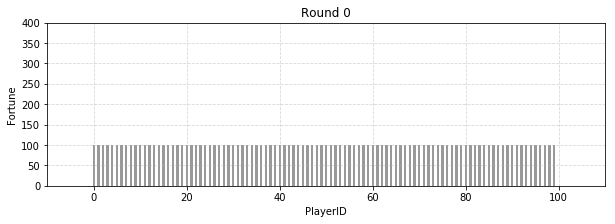

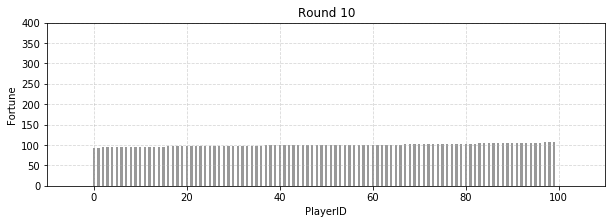

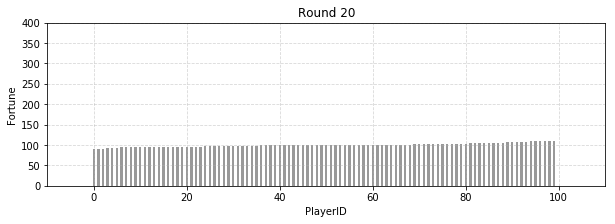

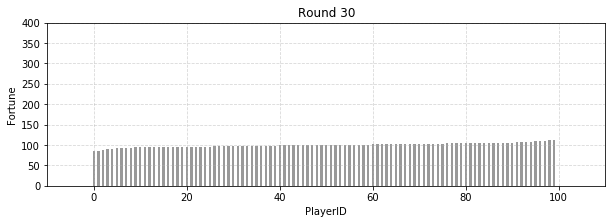

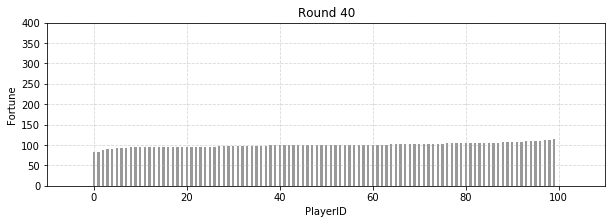

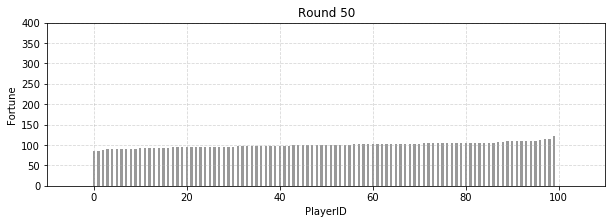

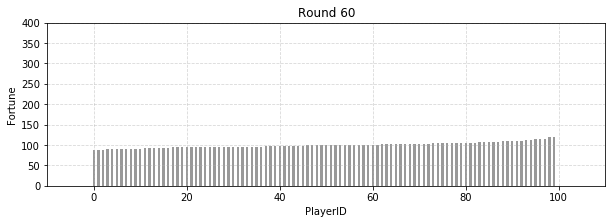

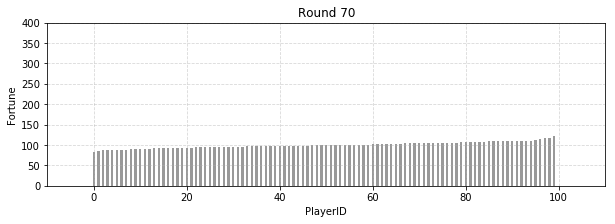

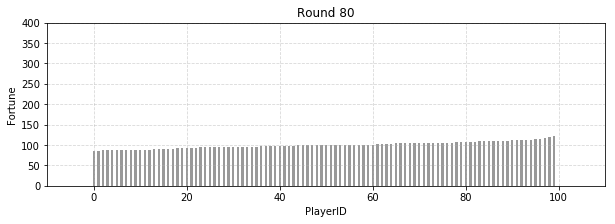

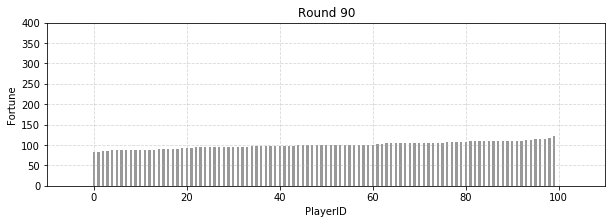

In [54]:
'''
（4）绘制柱状图
前100轮，按照每10轮绘制一次柱状图，查看财富变化情况
100至1000轮，按照每100轮绘制一次柱状图，查看财富变化情况
1000至17000轮，按照每400轮绘制一次柱状图，查看财富变化情况
** 每轮按照财富值排序绘制
'''
def graph2(data, start, end, length):
    for n in list(range(start, end,length)):
        datai =data.iloc[n].sort_values().reset_index()[n]
        plt.figure(figsize=(10,3))
        plt.bar(datai.index, datai.values,color='gray',alpha=0.8, width=0.5)
        plt.xlim((-10,110))
        plt.ylim((0,400))
        plt.title('Round %d' % n)
        plt.xlabel('PlayerID')
        plt.ylabel('Fortune')
        plt.grid(alpha=0.5, linestyle='--')

graph2(game1_result, 0, 100, 10)

In [56]:
'''
一些结论：
最后一轮中，最富有的人财富值为365元，相比于起始财富，翻了3.65倍。
10%的人掌握着28%的财富，20%的人掌握着51%的财富？
60%的人财富缩水至100元以下了
'''

round_17000_1 = pd.DataFrame({'money':game1_result.iloc[-1]}).sort_values(by = 'money',ascending = False).reset_index()
round_17000_1['fortune_pre'] = round_17000_1['money']/round_17000_1['money'].sum()
round_17000_1['fortune_cumsum'] = round_17000_1['fortune_pre'].cumsum()
round_17000_1.head(20)

,id,money,fortune_pre,fortune_cumsum
0,50,122.0,0.0122,0.0122
1,77,118.0,0.0118,0.0240
2,79,115.0,0.0115,0.0355
3,33,115.0,0.0115,0.0470
4,45,114.0,0.0114,0.0584
5,98,112.0,0.0112,0.0696
6,42,112.0,0.0112,0.0808
7,38,112.0,0.0112,0.0920
8,29,112.0,0.0112,0.1032
9,27,112.0,0.0112,0.1144
